In [1]:
!nvidia-smi

Tue Mar  3 01:59:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

1.15.0


**Initialize**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
import time
import os
from google.colab import files
import shutil

read_file=scipy.io.loadmat('Example_database.mat') # Please put Example_database.mat in right position
Input_train = np.zeros((3360,450,4))  # 80% for train data (total is 4200)
Input_test = np.zeros((840,450,4))   # 20% for test data (total is 4200)

# Assign train data from Example_database.mat
Input_train =np.array(read_file['train_1'])

# Assign test data from Example_database.mat
Input_test =np.array(read_file['test_1'])

train_label =np.array(read_file['train_label'])  
test_label =np.array(read_file['test_label'])  

X_train = Input_train
Y_train = train_label

X_test = Input_test
Y_test = test_label

# number of classes
n_classes= 42
# number of features
n_features=X_train.shape[1]



**Set Target Subject**

In [4]:
ID = 1 # Set True user ID (1~42)

print('ID',ID)

Y_train[np.where(Y_train!=ID)] = 0
Y_test[np.where(Y_test!=ID)] = 0
   

ID 1


In [5]:
print(np.unique(Y_train, return_counts=True)) # Check whether train target is only 1 while others are 0
print(np.unique(Y_test, return_counts=True)) # Check whether test target is only 1 while others are 0

(array([0, 1], dtype=uint8), array([3282,   78]))
(array([0, 1], dtype=uint8), array([818,  22]))


**Onehot Encoding + Data spliting and suffle**

In [6]:
enc = OneHotEncoder()
# randomly shuffle data before training and testing

randIndx = np.arange(X_train.shape[0])
np.random.shuffle(randIndx)

randIndx2 = np.arange(X_test.shape[0])
np.random.shuffle(randIndx2)

trainSamples=np.floor(X_train.shape[0]).astype(int)
testSamples=np.floor(X_test.shape[0]).astype(int) 

print(trainSamples)
print(testSamples)

X_train = X_train[randIndx,:,:] # Shuffle train data
X_test = X_test[randIndx2,:,:] # Shuffle test data
 
Y_train =enc.fit_transform(Y_train[randIndx].reshape(-1,1)).toarray() # Shuffle train target with one-hot encoding
Y_test =enc.fit_transform(Y_test[randIndx2].reshape(-1,1)).toarray() # Shuffle test target with one-hot encoding



3360
840


In [7]:
# Assign to train_data (target) / test_data (target)
train_data, train_target = X_train, Y_train
test_data, test_target = X_test, Y_test

print(train_data.shape,train_target.shape)
print(test_data.shape,test_target.shape)


(3360, 450, 4) (3360, 2)
(840, 450, 4) (840, 2)


**Network Structure**

In [0]:
class Model:

    def __init__(self, sess, name):

        self.sess = sess

        self.name = name

        self._build_net()

    def _build_net(self):

        with tf.variable_scope(self.name):

            self.training = tf.placeholder(tf.bool) # For turn-on/off dropout layer

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 450, 1]) # train/test data
            self.Y = tf.placeholder(tf.float32, [None, 2]) # train/test target
            self.learning_rate = tf.placeholder(tf.float32) # learning rate
            self.class_weights = tf.placeholder(tf.float32) # weight value for weighted-cross entropy
            self.reg_constant = tf.placeholder(tf.float32) # regularization constant

            # Convolutional Layer #1, length: 450x1 -> 271x50 (change of feature size)
            W1 = tf.Variable(tf.random_normal([180, 1, 50], stddev=0.01))
            conv1 = tf.nn.conv1d(self.X, W1, stride=1, padding='VALID')
            selu1 = tf.nn.selu(conv1) 
            dropout1 = tf.layers.dropout(inputs=selu1, rate=0.5, training=self.training)
            
            # Convolutional Layer #2, length: 271x50 -> 62x70 (change of feature size)
            W2 = tf.Variable(tf.random_normal([210, 50, 70], stddev=0.01))
            conv2 = tf.nn.conv1d(dropout1, W2, stride=1, padding='VALID')
            selu2 = tf.nn.selu(conv2)                                    
            dropout2 = tf.layers.dropout(inputs=selu2, rate=0.5, training=self.training)
            
        
            # FC layer, length: 62x70  -> 2 output (change of feature size)
            FC1 = tf.reshape(dropout2, [-1, 62*70])  
            FC_weight = tf.get_variable("FC_weight", shape=[62*70, 2], initializer=tf.contrib.layers.xavier_initializer())
            logits = tf.matmul(FC1,FC_weight) # Logit value
    
        # Define cost/loss & optimizer 
        reg_losses = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(FC_weight) # L2 regularization
        
        self.cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.Y, logits, self.class_weights)) 
        self.cost = self.cost + self.reg_constant * reg_losses

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) 

        self.sigmoid_out = tf.nn.sigmoid(logits) 
        self.predict = tf.cast(self.sigmoid_out[:,1], tf.float32) # Used for getting final train/test prediction
                    
        
    def get_predict(self, x_test, training = False):          

        return self.sess.run(self.predict, feed_dict={self.X: x_test, self.training: training})
    

    def get_cost(self, x_valid, y_valid, weights, reg, training = False):
        
        return self.sess.run(self.cost, feed_dict={self.X: x_valid, 
                                                   self.Y: y_valid, self.class_weights: weights, self.training: training, self.reg_constant: reg})


    def train(self, x_data, y_data, weights, learning, reg, training = True):

        return self.sess.run(self.optimizer, feed_dict={
             self.X: x_data, self.Y: y_data, self.class_weights: weights, self.learning_rate: learning, self.training: training, self.reg_constant: reg})
    

**Main**

In [9]:
### Hyperparameters

learning_rate = 0.0001
training_epochs = 60
batch_size = 336 # Mini-batch size: total: 3360(train)/840(test) 
num_cv = 10  # 10-fold cross validation
bag_size = 3024  # bag_size = train_data_size - batch_size
ear_epoch = 0

valid_cost = np.zeros((training_epochs,4))

# initialize
sess = tf.Session()

models = []
num_models = 4 

for m in range(num_models):
    print('Number of Model+Bagging {}'.format(m+1))
    models.append(Model(sess, "model" + str(m)))    


sess.run(tf.global_variables_initializer())


start_time = time.time() # time starts!

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
         
    total_batch = int(bag_size / batch_size)
    valid_cost_cv = [0,0,0,0]
    
    cv = KFold(n_splits=num_cv, shuffle=True)
    for train_index, test_index in cv.split(train_data): # For cross validation
        cv_train_data, cv_validate_data = train_data[train_index], train_data[test_index]
        cv_train_target, cv_validate_target = train_target[train_index], train_target[test_index]    
                    
        for m_idx, m in enumerate(models):
            # Assign different regularization constant. They are best hyperparameters from our searching.
            if m_idx==0: # DW feature
              training, validating = cv_train_data[:,:,0], cv_validate_data[:,:,0]
              training_target, validating_target = cv_train_target, cv_validate_target
              reg = 0.02 
            if m_idx==1: # TP feature
              training, validating = cv_train_data[:,:,1], cv_validate_data[:,:,1]
              training_target, validating_target = cv_train_target, cv_validate_target
              reg = 0.01            
            if m_idx==2: # FP feature
              training, validating = cv_train_data[:,:,2], cv_validate_data[:,:,2]
              training_target, validating_target = cv_train_target, cv_validate_target            
              reg = 0.02
            if m_idx==3: # Cubic feature
              training, validating = cv_train_data[:,:,3], cv_validate_data[:,:,3]
              training_target, validating_target = cv_train_target, cv_validate_target            
              reg = 0.01   

            training = np.reshape(training,[len(training),n_features,1])
            validating = np.reshape(validating,[len(validating),n_features,1])

            for i in range(total_batch):

                batch_xs, batch_ys = training[batch_size*i:batch_size*(i+1),:,:], training_target[batch_size*i:batch_size*(i+1)]                
                pos_weight = (n_classes - 1) # Weight value for weighted-cross entropy

                _ = m.train(batch_xs, batch_ys, pos_weight, learning_rate, reg)  # train model independently
            
            pos_weight = 1 # Usual cross entropy for validation/test set
            valid_cost_cv[m_idx] += m.get_cost(validating, validating_target, pos_weight, reg) 
            
    valid_cost[epoch] =np.divide(valid_cost_cv ,num_cv) 
    
    if ((epoch+1)%5) == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'Validating_cost_0 =', round(valid_cost[epoch,0],3),' Validating_cost_1 =', round(valid_cost[epoch,1],3),' Validating_cost_2 =', round(valid_cost[epoch,2],3),' Validating_cost_3 =', round(valid_cost[epoch,3],3)) 
       
        
print('Learning Finished!')

end_time = time.time() # time ends!

elapsed = end_time - start_time

print('Execution time:{:.2f} seconds'.format(elapsed))
print('Last validation error:{:.3f} '.format(valid_cost[-1,0]))
print('Last validation error:{:.3f} '.format(valid_cost[-1,1]))
print('Last validation error:{:.3f} '.format(valid_cost[-1,2]))
print('Last validation error:{:.3f} '.format(valid_cost[-1,3]))


Number of Model+Bagging 1
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Number of Model+Bagging 2
Number of Model+Bagging 3
Number of Model+Bagging 4
Learning Started!
Epoch: 0005 Validating_cost_0 = 0.739  Validating_cost_1 = 0.695  Validating_cost_2 = 0.66  Validating_cost_3 = 0.459
Epoch: 0010 Validating_cost_0 = 0.484  Validating_cost_1 = 0.477  Validating_cost_2 = 0.409  Validating_cost_3 = 0.333
Epoch: 0015 Validating_cost_0 = 0.311  Validating_cost_1 = 0.366  Validating_cost_2 = 0.262  Validating_cost_3 = 0.258
Epoch: 0020 Validating_cos

**Epoch vs Cost plot**

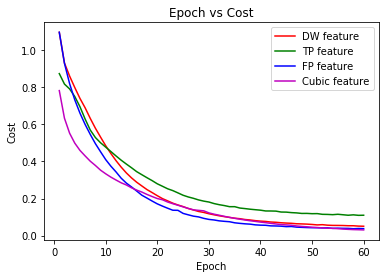

In [10]:
fig = plt.figure()
ax = plt.subplot(111)

x_axis = np.linspace(1.0, training_epochs, num=training_epochs)
ax.plot(x_axis, valid_cost[:,0],'r', label='DW feature')
ax.plot(x_axis, valid_cost[:,1],'g', label='TP feature')
ax.plot(x_axis, valid_cost[:,2],'b', label='FP feature')
ax.plot(x_axis, valid_cost[:,3],'m', label='Cubic feature')


ax.legend()
plt.title('Epoch vs Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')

plt.show()



**Weight calculator through training data**


In [0]:
thres = np.arange(0, 1.001, 0.001)

training_0 = np.reshape(train_data[:,:,0], [len(train_data[:,:,0]),n_features,1])
training_1 = np.reshape(train_data[:,:,1], [len(train_data[:,:,1]),n_features,1])
training_2 = np.reshape(train_data[:,:,2], [len(train_data[:,:,2]),n_features,1])
training_3 = np.reshape(train_data[:,:,3], [len(train_data[:,:,3]),n_features,1])

train_logit_0 =  models[0].get_predict(training_0) # Train score in Model-DW feature
train_logit_1 =  models[1].get_predict(training_1) # Train score in Model-TP feature
train_logit_2 =  models[2].get_predict(training_2) # Train score in Model-FP feature
train_logit_3 =  models[3].get_predict(training_3) # Train score in Model-Cubic feature

In [12]:
# Train Result in Model-DW feature

thres_matrix_train_0 = np.zeros((len(train_target),len(thres)))
total_matrix_train_0 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(train_target)):
        if train_logit_0[i] < thres[j]:
            thres_matrix_train_0[i,j] = 0
        else:
            thres_matrix_train_0[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_train_0[:,i], train_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_train_0[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_train_0[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(train_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_train_0[i,:] = ACC_test, FAR_test, FRR_test, Recall_test


EER_loc_test = np.argmin(abs(total_matrix_train_0[:,1] - total_matrix_train_0[:,2]))
print('EER: {:.3f} '.format((total_matrix_train_0[EER_loc_test,1]+total_matrix_train_0[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_train_0[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_train_0[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_train_0[EER_loc_test,0]))

ACC_0 = total_matrix_train_0[EER_loc_test,0]

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


In [13]:
# Train Result in Model-TP feature

thres_matrix_train_1 = np.zeros((len(train_target),len(thres)))
total_matrix_train_1 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(train_target)):
        if train_logit_1[i] < thres[j]:
            thres_matrix_train_1[i,j] = 0
        else:
            thres_matrix_train_1[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_train_1[:,i], train_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_train_1[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_train_1[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(train_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_train_1[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_train_1[:,1] - total_matrix_train_1[:,2]))
print('EER: {:.3f} '.format((total_matrix_train_1[EER_loc_test,1]+total_matrix_train_1[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_train_1[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_train_1[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_train_1[EER_loc_test,0]))

ACC_1 = total_matrix_train_1[EER_loc_test,0]

EER: 0.013 
FRR at EER: 0.013 
FAR at EER: 0.012 
Accuracy at EER: 0.988 


In [14]:
# Train Result in Model-FP feature

thres_matrix_train_2 = np.zeros((len(train_target),len(thres)))
total_matrix_train_2 = np.zeros((len(thres),4)) 


for j in range(len(thres)):
    for i in range(len(train_target)):
        if train_logit_2[i] < thres[j]:
            thres_matrix_train_2[i,j] = 0
        else:
            thres_matrix_train_2[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_train_2[:,i], train_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_train_2[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_train_2[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(train_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_train_2[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_train_2[:,1] - total_matrix_train_2[:,2]))
print('EER: {:.3f} '.format((total_matrix_train_2[EER_loc_test,1]+total_matrix_train_2[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_train_2[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_train_2[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_train_2[EER_loc_test,0]))

ACC_2 = total_matrix_train_2[EER_loc_test,0]

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


In [15]:
# Train Result in Model-Cubic feature

thres_matrix_train_3 = np.zeros((len(train_target),len(thres)))
total_matrix_train_3 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(train_target)):
        if train_logit_3[i] < thres[j]:
            thres_matrix_train_3[i,j] = 0
        else:
            thres_matrix_train_3[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_train_3[:,i], train_target[:,1])
    unique2, True_pos_neg_test = np.unique(thres_matrix_train_3[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_train_3[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(train_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_train_3[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_train_3[:,1] - total_matrix_train_3[:,2]))
print('EER: {:.3f} '.format((total_matrix_train_3[EER_loc_test,1]+total_matrix_train_3[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_train_3[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_train_3[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_train_3[EER_loc_test,0]))

ACC_3 = total_matrix_train_3[EER_loc_test,0]

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


**Result of test set in individual model**

In [0]:
   
testing_0 = np.reshape(test_data[:,:,0], [len(test_data[:,:,0]),n_features,1])
testing_1 = np.reshape(test_data[:,:,1], [len(test_data[:,:,1]),n_features,1])
testing_2 = np.reshape(test_data[:,:,2], [len(test_data[:,:,2]),n_features,1])
testing_3 = np.reshape(test_data[:,:,3], [len(test_data[:,:,3]),n_features,1])

start_time_test = time.time() # time starts!

test_logit_0 =  models[0].get_predict(testing_0) # Test score in Model-DW feature
test_logit_1 =  models[1].get_predict(testing_1) # Test score in Model-TP feature
test_logit_2 =  models[2].get_predict(testing_2) # Test score in Model-FP feature
test_logit_3 =  models[3].get_predict(testing_3) # Test score in Model-Cubic feature    


**Final Fusion**

In [17]:
# Assign the intrinsic weight value for each model
weight_0 = round((ACC_0) / (ACC_0+ACC_1+ACC_2+ACC_3),3) 
weight_1 = round((ACC_1) / (ACC_0+ACC_1+ACC_2+ACC_3),3)
weight_2 = round((ACC_2) / (ACC_0+ACC_1+ACC_2+ACC_3),3)
weight_3 = round((ACC_3) / (ACC_0+ACC_1+ACC_2+ACC_3),3)

thres_matrix_test = np.zeros((len(test_target),len(thres)))
total_matrix_test = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)

print('Weight0: ',weight_0,' Weight1: ',weight_1, ' Weight2: ',weight_2, ' Weight3: ',weight_3)

test_logit = (weight_0*test_logit_0 + weight_1*test_logit_1 + weight_2*test_logit_2 + weight_3*test_logit_3) # Weight sum score fusion


for j in range(len(thres)):
    for i in range(len(test_target)):
        if test_logit[i] < thres[j]:
            thres_matrix_test[i,j] = 0
        else:
            thres_matrix_test[i,j] = 1


unique, counts = np.unique(test_target[:,1], return_counts=True)
print('Test set dictionary: ',dict(zip(unique, counts)))


for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_test[:,i], test_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_test[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

test_time = time.time() - start_time_test 

print('Execution Test time:{:.2f} seconds'.format(test_time))

Weight0:  0.251  Weight1:  0.248  Weight2:  0.251  Weight3:  0.251
Test set dictionary:  {0.0: 818, 1.0: 22}
Execution Test time:2.23 seconds


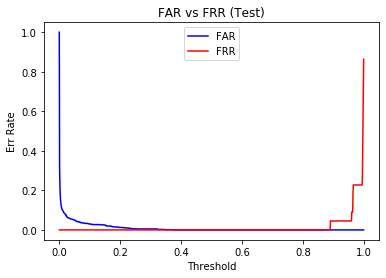

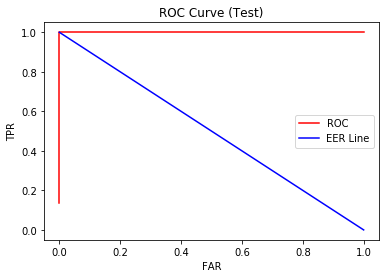

EER: 0.000 
FRR at EER: 0.000 
FAR at EER: 0.000 
Accuracy at EER: 1.000 


In [18]:
fig4 = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_test[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_test[:,2],'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Test)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig5 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_test[:,1], total_matrix_test[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Test)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_test[:,1] - total_matrix_test[:,2]))
print('EER: {:.3f} '.format((total_matrix_test[EER_loc_test,1]+total_matrix_test[EER_loc_test,2])/2))
print('FRR at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,2]))
print('FAR at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,1]))
print('Accuracy at EER: {:.3f} '.format(total_matrix_test[EER_loc_test,0]))

